In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)
test_image_generator = ImageDataGenerator(rescale=1/255)

train_data_gen = train_image_generator.flow_from_directory(
                                            directory=train_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=100
                                        )


val_data_gen = validation_image_generator.flow_from_directory(
                                            directory=validation_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=100)

test_data_gen = test_image_generator.flow_from_directory(
                                            directory=PATH,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            classes=['test'],
                                            shuffle=False
                                            )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


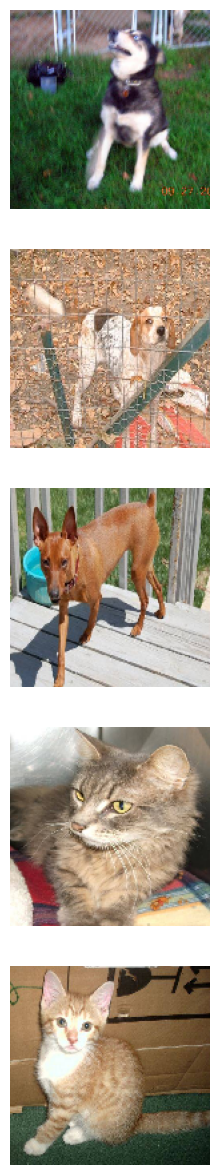

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
train_image_generator = ImageDataGenerator(rotation_range=15,
                                            shear_range=0.1,
                                            zoom_range=0.2,
                                            horizontal_flip=True,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            fill_mode="nearest",
                                            rescale=1./255)

Found 2000 images belonging to 2 classes.


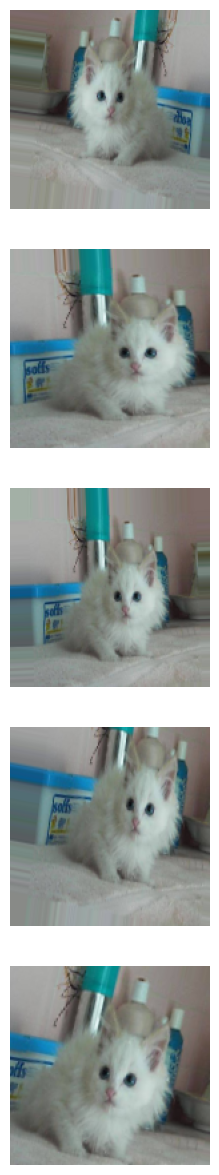

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=(IMG_HEIGHT,IMG_WIDTH,3,)))
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [ ]:
# compile the model
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])


In [ ]:
train_data_gen.n//batch_size


15

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  mode="min",
                                  patience=3,
                                  restore_best_weights=True)


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 150, 150, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
from gc import callbacks
history = model.fit(train_data_gen,
                          epochs=epochs,
                          steps_per_epoch= train_data_gen.n//batch_size,
                          batch_size = batch_size,
                          validation_data=val_data_gen,
                          validation_steps = val_data_gen.n//batch_size,
                          callbacks=[callback])


Epoch 1/25
15/15 [==============================] - 86s 6s/step - loss: 0.4337 - accuracy: 0.8082 - val_loss: 0.4830 - val_accuracy: 0.7600
Epoch 2/25
15/15 [==============================] - 86s 6s/step - loss: 0.4321 - accuracy: 0.7981 - val_loss: 0.4691 - val_accuracy: 0.7846
Epoch 3/25
15/15 [==============================] - 86s 6s/step - loss: 0.4416 - accuracy: 0.7922 - val_loss: 0.4471 - val_accuracy: 0.7902
Epoch 4/25
15/15 [==============================] - 89s 6s/step - loss: 0.4405 - accuracy: 0.7922 - val_loss: 0.4945 - val_accuracy: 0.7489
Epoch 5/25
15/15 [==============================] - 84s 6s/step - loss: 0.4153 - accuracy: 0.8072 - val_loss: 0.4905 - val_accuracy: 0.7734
Epoch 6/25
15/15 [==============================] - 87s 6s/step - loss: 0.4176 - accuracy: 0.8045 - val_loss: 0.4683 - val_accuracy: 0.7846


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

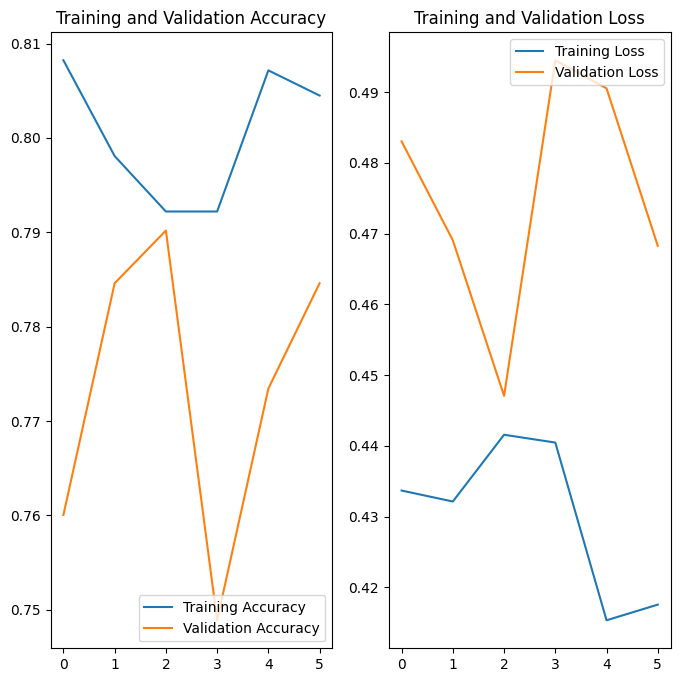

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 604ms/step


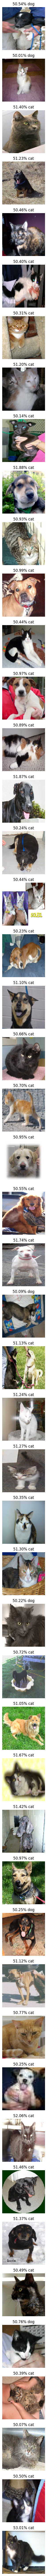

In [ ]:
probabilities = model.predict(test_data_gen).flatten()
test_images, _ = next(test_data_gen)
plotImages(test_images, probabilities = probabilities)

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.52% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
